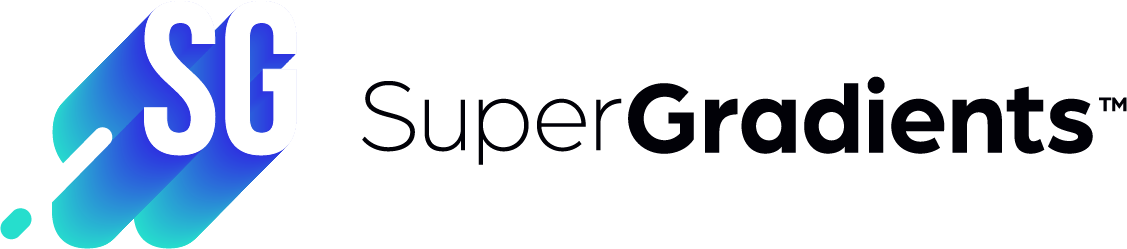

# SuperGradients Predict

In this tutorial we will use SG pretrained models to predict on an image. 

The notebook is divided into 3 tasks:
1. Semantic segmentation
2. Object detection
3. Classification

Each task is divided into 3 sections:
1. Load an image
2. Load a pretrained model
3. Inferenece


#Install SG and deci's dependecies


In [1]:
! pip install super-gradients gwpy &> /dev/null

In [2]:
! pip install matplotlib==3.1.3 &> /dev/null


# 1. Object detection

For the sake of this presentation, We'll use COCO dataset that can be found [here](https://cocodataset.org/#home).

We will use YoloX-S model for inference.



### A. Load an image

In [72]:
import requests
from PIL import Image
from io import BytesIO

# Image can be both uploaded to colab server or by a direct URL
image_path = "https://www.gulfplaceon30a.com/wp-content/uploads/2020/01/yolo1.jpg"

# Load image from url
response = requests.get(image_path)

# Get PIL image
image = Image.open(BytesIO(response.content))

<class 'PIL.JpegImagePlugin.JpegImageFile'> (960, 960)


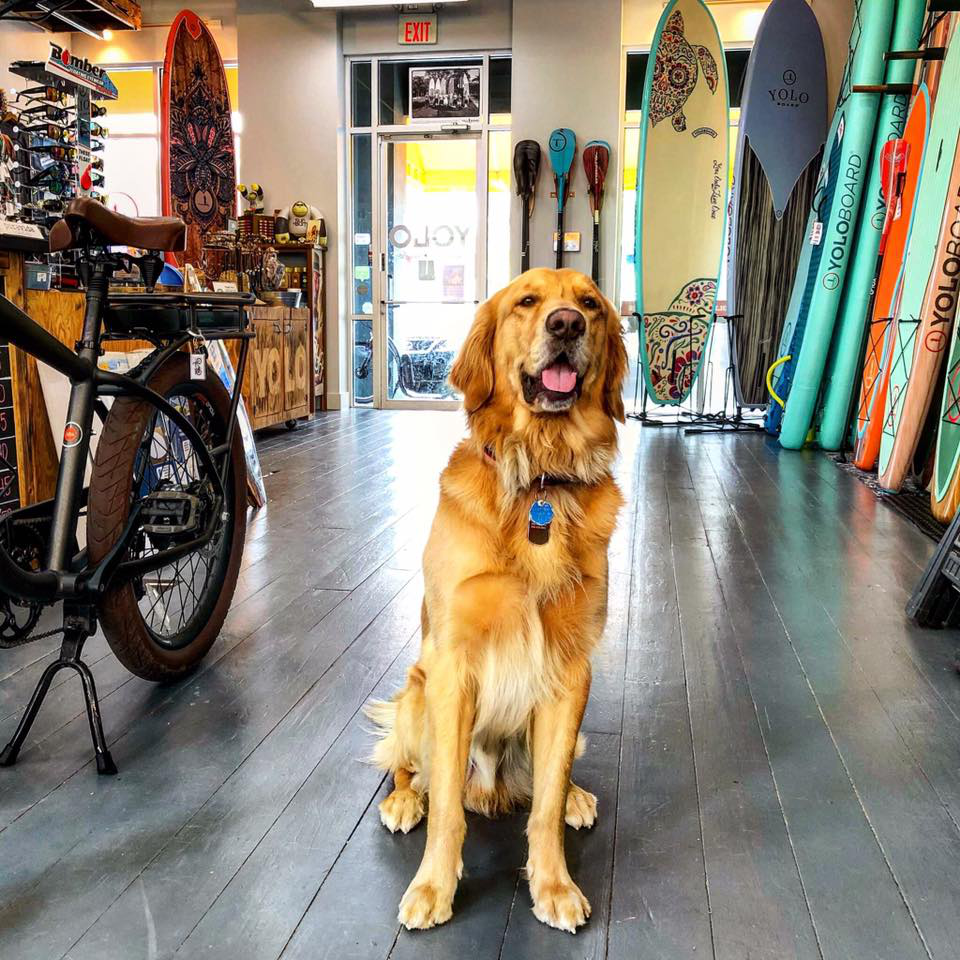

In [73]:
# Visualize
print(type(image), image.size)
image

### Preprocess

In [74]:
import torchvision.transforms as transforms
import torch
# Prepare preprcoess transformations
# We resize to [640, 640] by COCO's dataset default, which the model was pretrained on.
preprocess = transforms.Compose([
    transforms.Resize([640, 640]),
    transforms.PILToTensor()
])

# Run preprocess on image. unsqueeze for [Batch x Channels x Width x Height] format
transformed_image = preprocess(image).float().unsqueeze(0)

### B. Load a pretrained model

In [81]:
from super_gradients.training import models

# Get pretrained model from super-gradients repository.
model = models.get("yolox_s", pretrained_weights="coco", num_classes=80)

model_factory -WARNING- Passing num_classes through arch_params is dperecated and will be removed in the next version. Pass num_classes explicitly to models.get


### C. Inference

In [82]:
model.eval()

# Predict using SG model
with torch.no_grad():
  raw_predictions = model(transformed_image)

### Postprocess

In [83]:
from super_gradients.training.models.detection_models.yolo_base import YoloPostPredictionCallback
# Callback uses NMS, confidence threshold
predictions = YoloPostPredictionCallback(conf=0.1, iou=0.4)(raw_predictions)[0].numpy()

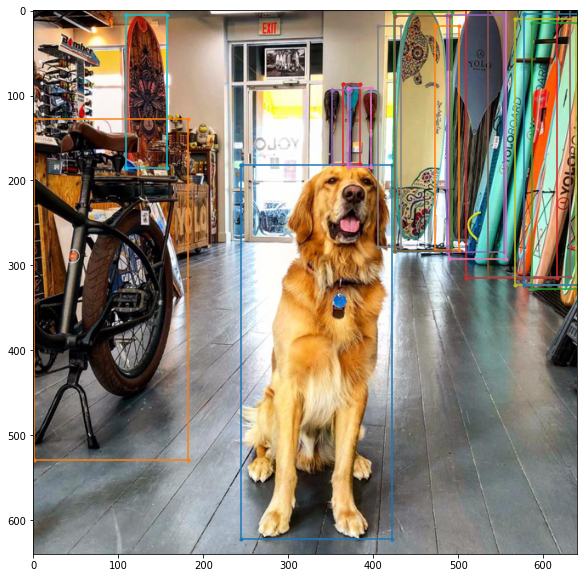

In [84]:
import matplotlib.pyplot as plt

# Visualize results
boxes = predictions[:, 0:4]
plt.figure(figsize=(10, 10))
plt.plot(boxes[:, [0, 2, 2, 0, 0]].T, boxes[:, [1, 1, 3, 3, 1]].T, '.-')
plt.imshow(image.resize([640, 640]))
plt.show()

# 2. Semantic segmentation


For the sake of this presentation, We'll use Supervise.ly dataset that can be found [here](https://docs.supervise.ly/).

We will use PP-Lite-T model for inference.

### A. Load an image

In [155]:
import requests
from PIL import Image
from io import BytesIO

# Image can be both uploaded to colab server or by a direct URL
url =  "https://s.hs-data.com/bilder/spieler/gross/128069.jpg"

# Load image from url
response = requests.get(url)

# Get PIL image
image = Image.open(BytesIO(response.content))

(400, 500)


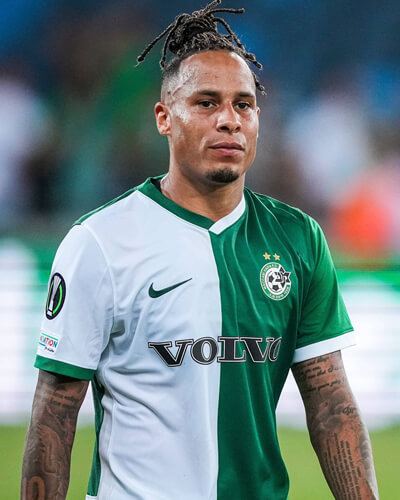

In [156]:
# Visualize
print(image.size)
image

### Preprocess

In [157]:
import torchvision.transforms as transforms
import torch

# Prepare preprcoess transformations
pre_proccess = transforms.Compose([
    transforms.Resize([640, 640]),
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])

# Run preprocess on image. unsqueeze for [Batch x Channels x Width x Height] format
transformed_image = pre_proccess(image).unsqueeze(0)

### B. Load a pretrained model


In [158]:
# We will use weights that have been created with pp-lite-seg model on the supervise.ly dataset.
# Get pre-trained weights 
! wget "https://deci-pretrained-models.s3.amazonaws.com/ppliteseg/supervisely/pplite_t/ckpt_best.pth"

--2022-09-15 14:54:44--  https://deci-pretrained-models.s3.amazonaws.com/ppliteseg/supervisely/pplite_t/ckpt_best.pth
Resolving deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)... 52.217.194.153
Connecting to deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)|52.217.194.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96694741 (92M) [binary/octet-stream]
Saving to: ‘ckpt_best.pth.5’

ckpt_best.pth.5     100%[===================>]  92.21M  57.0MB/s    in 1.6s    

2022-09-15 14:54:46 (57.0 MB/s) - ‘ckpt_best.pth.5’ saved [96694741/96694741]



In [159]:
# Get model from super-gradients repository.
model = models.get("pp_lite_t_seg",
                   num_classes=1,
                   checkpoint_path='ckpt_best.pth')

model_factory -WARNING- Passing num_classes through arch_params is dperecated and will be removed in the next version. Pass num_classes explicitly to models.get


### C. Inferenece

In [160]:
# Predict using SG model
model = model.eval()
mask = model(transformed_image)

### Postprocess

In [161]:
# Run post-proccess - apply sigmoid to output probabilities, then apply hard
# threshold of 0.5 for binary mask prediction. 
mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = transforms.ToPILImage()(mask.float())

Text(0.5, 1.0, 'Original')

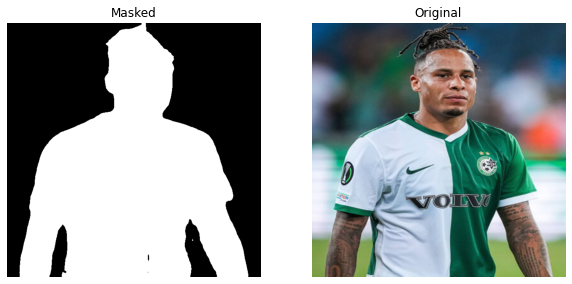

In [96]:
# Visualize
import numpy as np
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)  
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Masked")
fig.add_subplot(1, 2, 2)  
plt.imshow(transforms.Resize([640, 640])(image))
plt.axis('off')
plt.title("Original")

# 3. Classification


For the sake of this presentation, We'll use ImageNet dataset that can be found [here](https://www.image-net.org/).

We will use ResNet-18 model for inference.

### A. Load an image

In [150]:
import requests
from PIL import Image
from io import BytesIO

# Image can be both uploaded to colab server or by a direct URL
url = "https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8NHx8ZG9nc3xlbnwwfHwwfHw%3D&w=1000&q=80"

# Load image from url
response = requests.get(url)

# Get PIL image
image = Image.open(BytesIO(response.content))

<class 'PIL.JpegImagePlugin.JpegImageFile'> (1000, 667)


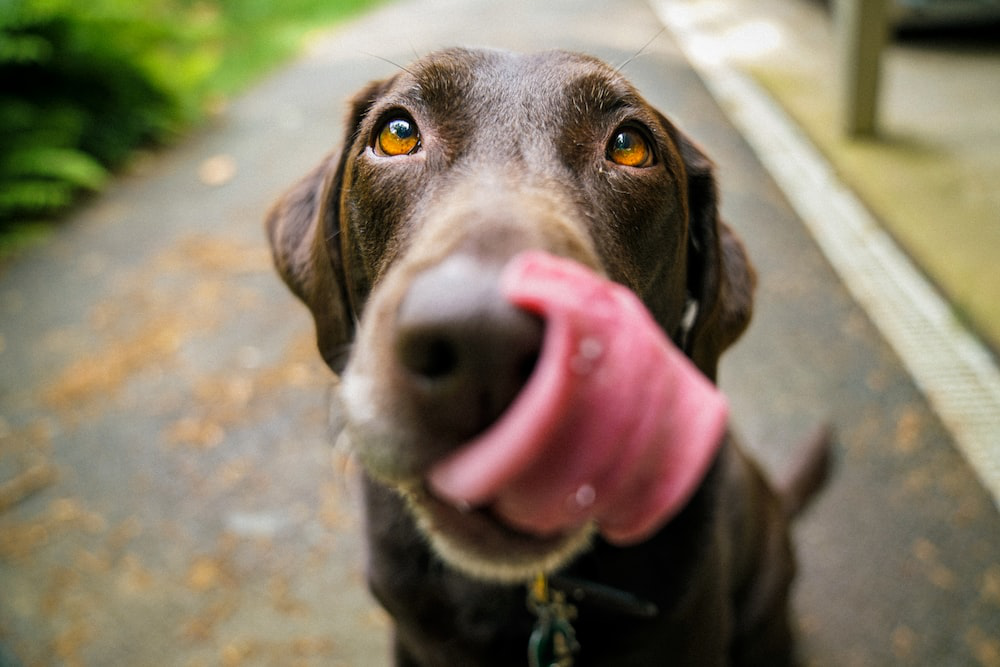

In [151]:
# Visualize
print(type(image), image.size)
image

### Preprocess

In [152]:
import torchvision.transforms as transforms

# Prepare preprcoess transformations
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])

# Run preprocess on image. unsqueeze for [Batch x Channels x Width x Height] format
input_tensor = preprocess(image).unsqueeze(0)

### B. Load a pretrained model

In [136]:
# Get pretrained model
model = models.get("resnet18", pretrained_weights="imagenet", num_classes=1000)

model_factory -WARNING- Passing num_classes through arch_params is dperecated and will be removed in the next version. Pass num_classes explicitly to models.get


### C. Inference

In [137]:
! wget "https://raw.githubusercontent.com/alexisbcook/ResNetCAM-keras/master/imagenet1000_clsid_to_human.txt"

--2022-09-15 14:50:21--  https://raw.githubusercontent.com/alexisbcook/ResNetCAM-keras/master/imagenet1000_clsid_to_human.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsid_to_human.txt.3’

imagenet1000_clsid_ 100%[===================>]  29.85K  --.-KB/s    in 0s      

2022-09-15 14:50:21 (117 MB/s) - ‘imagenet1000_clsid_to_human.txt.3’ saved [30564/30564]



In [138]:
import json

# Parse image net text file with all classes (becuase we do not load the ImageNet dataset module, 
# we currently can not access the dataloaders dataset meta-data, including classes list) 
imagenet_classes = [None] * 1000
with open("imagenet1000_clsid_to_human.txt") as f:
  lines = f.readlines()
  for line in lines:
    id = line.split(":")[0].replace("{", "")
    classes = line.split(":")[1].replace(",", "")
    imagenet_classes[int(id)] = classes

In [153]:
# Run predict
model.eval()

output = model(input_tensor)
predicted = imagenet_classes[torch.argmax(output)]

 'basset basset hound'



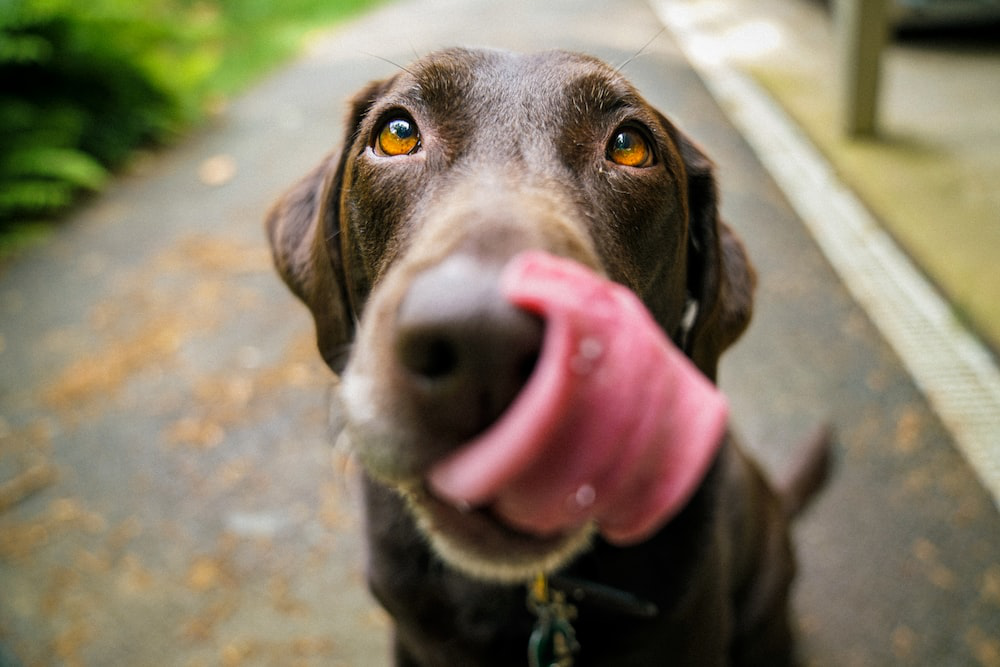

In [154]:
print(predicted)
image